# Analysis of Financial Time Series with Persistent Homology

<hr>
<hr>

## a. Notebook description

We aim to analyze the evolution of daily returns of four key US stock markets indices -- DowJones, Nasdaq, Russell2000, SP500 -- over the period from 1989 to 2016 using persistent homology. To do so, we will follow the approach proposed by Marian Gidea and Yuri Katz in "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)."

This project aims to reproduce the paper's experiments and further explore some variants if possible.

#### Short summary of the paper

The paper proposes a Topological Data Analysis (TDA) method to extract topological features from a multivariate time series with values in $R^d$ ($d = 4$ here as we consider four stock market indices). Features are computed from data slices extracted from the original time series via a sliding time window of length $w$. Using Vietoris-Rips filtrations, a persistence diagram and then a persistence landscape is computeed for each data slice, also called point cloud. A landscape being yielded per time window, each is further proceded into a single real value, then recombined into a final time series. The paper highlights that current and future market behavior can be evidenced using that final time series.

## b. Notebook Steps

<u>**Step 1**</u> -- Perform simple data exploration on the available dataset and note important/applicable points from the provided paper (we will specifically pay attention to Sections 3.1 and 4).

<u>**Step 2**</u> -- Write a function to compute persistence landscapes *WITHOUT* using the GUDHI library. This function should take as input a persistence diagram $D$ (in the GUDHI format), a dimension $k$, the endpoints
$x_{min}$, $x_{max}$ of an interval, the number $n$ of nodes of a regular grid on the interval $[x_{min}, x_{max}]$ and a number of landscapes $m$, and should output an $m \times n$ array storing the values of the first $m$ landscapes of the persistence diagram $D$ on the nodes of the grid. Check on some simple examples that your code
is correct.

<u>**Step 3**</u> -- Use the landscape function to run the experiments done in Section 4 of the paper, using windows of length $w = 40$ and $w = 80$ and $w = 120$. Compare your results to the ones provided in the article: are they similar or not?

<u>**Step 4**</u> -- Propose and experiment other methods, than just computing the norm of landscapes and briefly discuss and compare your results to the ones in Section 4 of the paper.

## c. Library Imports

In [1]:
import gudhi as gd
import gudhi.representations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle as pickle
from pylab import *

%matplotlib inline

## d. Function Declarations

In [27]:
def compute_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given an input standardized stock price dataframe, transforms
    the dataframe in its relative-valued counterpart:
    - prices are transformed into their log-return
    - volume is transformed into a percent change
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    # Computes the log-returns for each price column
    price_columns = ["open", "high", "low", "close", "adj_close"]
    for column in price_columns:
        log_price            = np.log(new_df[column])
        log_price_shifted    = np.log(new_df[column].shift(1))
        new_df[column+"_lr"] = log_price - log_price_shifted
    # Computes the volume percent change
    new_df["volume_pct_change"]=new_df["volume"].pct_change()
    return new_df

def compute_persistence_diagram(
    point_cloud:  np.ndarray,
    rips_complex: bool        = True, 
    print_graph:  bool        = False,
    memory_saving: tuple      = (False, 1)
) -> np.ndarray:
    """
    Given an input point cloud data set, computes the corresponding 
    persistence diagram (only for 1-d loops as in the paper).
    the method relies on using alpha filtration
    """
    # Computes the Vietoris-Rips complex, its barcode and 1-loop diagram
    if rips_complex:
        simplex   = gd.RipsComplex(points = point_cloud)
        simplex   = simplex.create_simplex_tree(max_dimension = 2)
        bar_codes = simplex.persistence()
        if memory_saving[0]:
            simplex = simplex.persistence_intervals_in_dimension(memory_saving[1])
    # Computes the alpha complex, its varcode and 1-loop diagram
    else:
        simplex   = gd.AlphaComplex(points = point_cloud)
        simplex   = simplex.create_simplex_tree()
        bar_codes = [x for x in simplex.persistence() if x[0]<=1]
        if memory_saving[0]:
            simplex = simplex.persistence_intervals_in_dimension(memory_saving[1])
    # prints the persistence diagram graph if requested
    if print_graph: gd.plot_persistence_diagram(bar_codes)
    # the returned diagram comprises the birth and death of 1-loops
    return simplex

def compute_persistence_diagrams(
    data:         pd.DataFrame, 
    w:            int, 
    rips_complex: bool          = True,
    memory_saving: tuple        = (False, 1)
) -> np.ndarray:
    """
    Given an input time series, computes the corresponding 
    persistence diagram given a shifting window of size w.
    """
    data = data.values
    diagrams = []
    for slc in range(data.shape[0]-w):
        point_cloud = data[slc:slc+w]
        diagram     = compute_persistence_diagram(point_cloud, 
                                                  rips_complex,
                                                  False,
                                                  memory_saving)
        diagrams.append(diagram)
    return diagrams

def compute_persistence_landscape(
    diagram:            np.ndarray,         # diagram range
    endpoints:          list,               # endpoints
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    """
    Given a persistence diagram of 1D loops of a given
    time series, computes the corresponding persistence landscape.
    Inspired from: https://github.com/MathieuCarriere/sklearn-tda/
                   blob/master/sklearn_tda/vector_methods.py
    """
    # If the diagram is empty, return an empty landscape
    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((n_landscapes, resolution))
    # Renames the min-max range of the given diagram
    diagram_range = endpoints
    # Extracts the homology class from the diagram in case the 
    # computation mode  is not memory-saving. I.e. the dimension
    # class was not pre-fetched at the diagram computation level
    if not memory_saving:
        diagram = diagram.persistence_intervals_in_dimension(homology_dimension)
    # Initializes important variables
    x_range        =  np.linspace(diagram_range[0], 
                                  diagram_range[1],
                                  resolution)
    step           = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = \
        np.zeros([n_landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]
    # Initializes important anonymous functions
    compute_x_subrange = lambda x: int(np.ceil(x/step))
    # Computes the persistence landscape coverage, here
    # the x- and y-axes ranges
    for x, y in diagram:
        # Populates thex-axis range as defined for each 
        # persistence diagram point
        min_point = x - diagram_range[0]
        mid_point = 0.5*(x+y) - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)
        # Populates the y-axis values given the computed
        # x-axis range for that part of the resulting landscape
        if minimum_x<resolution and maximum_x>0:
            y_value = diagram_range[0] + minimum_x * step - x
            for z in range(minimum_x, middle_x):
                computed_y_values[z].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x * step
            for z in range(middle_x, maximum_x):
                computed_y_values[z].append(y_value)
                y_value -= step
    # Computes for each resolution the corresponding landscape
    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(n_landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = \
                computed_y_values[i][j]
    return computed_landscapes_at_given_resolution
    
def compute_persistence_landscapes(
    diagrams:           np.ndarray,         # diagram D
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    """
    Given a list of persistence diagrams of 1D loops of a given
    time series, computes the corresponding persistence landscapes.
    """
    k    = homology_dimension
    # Declares the anonymous functions helping to compute the
    # diagram endpoints different depending on the memory saving mode
    if memory_saving:
        minp = lambda d: np.min(d) if len(d)>0 else 0
        maxp = lambda d: np.max(d) if len(d)>0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")
    # Transforms all diagrams into landscapes
    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            homology_dimension,       # k dimensions
            n_landscapes,             # m landscapes
            resolution,               # n nodes
            memory_saving
        ) for diag in diagrams
    ]
    return landscapes

def compute_persistence_landscape_norms(landscapes: list) -> np.ndarray:
    """
    Given a list/time series of persistence landscape, computes
    the corresponding normalized L1 and L2 time series
    """
    norms_1 = [np.linalg.norm(ls, 1) for ls in landscapes]
    norms_2 = [np.linalg.norm(ls, 2) for ls in landscapes]
    norms_1 = norms_1/np.linalg.norm(norms_1)
    norms_2 = norms_2/np.linalg.norm(norms_2)
    return np.array([norms_1, norms_2]).T

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the column names of the dataframe:
    - lower casing
    - space swapped for underscore
    """
    # Declares useful anonymous function
    format_column_name = lambda x: x.lower().replace(" ", "_")
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    new_df.columns = list(map(format_column_name, new_df.columns))
    return new_df

def henon_map(
    a:           float, 
    b:           float, 
    n:           int, 
    x0:          float, 
    y0:          float,
    print_graph: bool    = True
) -> np.ndarray:
    """
    Implements a classic hénon map process.
    """
    hm = [(x0, y0)]
    for step in range(0, n):
        y = hm[-1][0]
        x = 1 - a*y**2 + b*hm[-1][1]
        hm.append((x, y))
    hm = np.array(hm)
    if print_graph:
        plt.figure(figsize=(12,2))
        plt.plot(hm[:150,0])
        plt.title("Firsts 150 points of the henon map/attractor system")
        plt.show()
        plt.figure(figsize=(12,12))
        plt.scatter(hm[0,0], hm[0,1], c="red")
        plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
        plt.title("Attractor")
        plt.show()
    return hm[:,0]
    
def noisy_henon_map(
    b:               float, 
    timestep:        float, 
    noise_intensity: float, 
    x0:              float, 
    y0:              float,
    print_graph:     bool   = False
) -> np.ndarray:
    """
    Implements the hénon map with noise modification implemented
    in the paper.
    """
    hm = [(x0, y0)]
    As = [0]
    while As[-1]<1.4:
        random_move = np.random.normal(0,1)*np.sqrt(timestep)
        x = 1 - As[-1]*hm[-1][0]**2 + b*hm[-1][1] + \
            noise_intensity*random_move
        y = hm[-1][0] + noise_intensity*random_move
        next_step = As[-1]+timestep if As[-1]+timestep <=1.4 else 1.4
        As.append(next_step)
        hm.append((x, y))
    hm = np.array(hm)
    if print_graph:
        plt.figure(figsize=(12,2))
        plt.plot(As, hm[:,0])
        plt.title("Henon map/attractor system with Gaussian noise")
        plt.show()
        plt.figure(figsize=(12,12))
        plt.scatter(hm[0,0], hm[0,1], c="red")
        plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
        plt.title("Attractor with Gaussian nosie")
        plt.show()
    return hm[:,0]

def plot_price_data(
    df_list: list,  
    legend: list, 
    target_column: str,
    title: str
) -> None:
    """
    Given a list of standardized stock price data, plots the
    Adjusted Close value across the whole available timeline.
    """
    plt.figure()
    # Fixes x-ticks interval to c. a year
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
    for df in df_list:
        plt.plot(df["date"].tolist(), 
                 df[[target_column]],
                 linewidth=.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(legend)
    plt.show()
    
def reverse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Revert the order of a dataframe.
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()[::-1]
    new_df.index = range(0, len(df))
    return new_df

def white_noise_with_gamma_inverse_var(n=100):
    """
    Implements the white noise with gamma-distributed inverse
    variance generation implemented in the paper.
    """
    # Declares the gamma distribution parameters
    alpha = 8
    beta = 1
    simulation = None
    # Performs 100 realization of a 4D 100-point cloud dataset
    for realization in range(100):
        # Updates alpha parameter if need be
        if realization > 75:
            alpha -= 0.25
        gamma_variance = np.random.gamma(shape = alpha, scale = beta)
        cloud_set = np.random.normal(0, 1/np.sqrt(np.random.gamma(shape = alpha, scale = beta)),
                                     (4, n))
        if simulation is None:
            simulation = cloud_set
        else:
            simulation = np.concatenate([simulation, cloud_set], axis=1)
    return simulation

def white_noise_with_growing_var(n_realization: int) -> dict:
    """
    Implements the white noise with growing variance generation 
    implemented in the paper.
    """
    simulations = {}
    # base variance is grown from 1 to 10, i.e. 10 simulations
    for var in range(1, 11):
        full_simulation = None
        # n realization of 4 time series are performed per
        # simulations
        for n in range(n_realization):
            ts_simulation = None
            for time_series in range(4):
                update_var = var + np.random.uniform(-0.1, 0.1)
                realization = np.random.normal(0, update_var, (1, 100))
                if ts_simulation is None:
                    ts_simulation = realization
                else:
                    ts_simulation = np.concatenate([ts_simulation,
                                                    realization])
            if full_simulation is None:
                full_simulation = ts_simulation
            else:
                full_simulation = np.concatenate([full_simulation,
                                                  ts_simulation], axis=1)
        simulations[var] = full_simulation.reshape(4, -1)
    return simulations

<hr>
<hr>

# 1. Step 1 - Paper Summary and Data Pre-processing/Exploration

### 1.1 Notes on the paper

<u>***The paper's motivation(s)***:</u>

Sharp changes in the behavior of financial markets have led to deep social, political and economic upheavals. The destabilisation of economies, countries, and people's lives at a systemic level (e.g. 2000-2001 Dotcom Bubble, 2008 Financial Crisis, 2012 Euro Debt Crisis, etc.) has highlighted the regulatory need for predicting such changes.

This has translated into a large field of research in econometrics (e.g. the development of the co-value-at-risk, or CoVaR, by Tobias Adrian and Markus Brunnermeier in the [paper of the same name](https://www.aeaweb.org/articles?id=10.1257/aer.20120555), American Economic Review, Vol.106, No.7, July 2016) which exerts a strong influence on policymaking worldwide. However, predicting rises in volatility and even crashes is a harduous task that is not yet solved, and will likely never be.

Marian Gidea and Yuri Katz proposes in their paper "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" to use persistence homology to evidence such sharp changes in financial markets. As financial markets are complex systems and hard to model, TDA can help highlight features and underlying behavior in the data without having to model the underlying stochastic process.

<u>***The paper's input data and its formatting***:</u>

The paper relies on analyzing a 4-dimensional time series built from the daily log-returns (preprocessed from daily adjusted closing prices) of 4 key US stock market indexes: S&P500, Dow Jones, NASDAQ, Russel 2000 (See Section 1.3 of this notebook for more information on log-returns).

The paper is looking to transform this pre-processed financial market data into a topological embedding (persistence landscapes) useful for perform statistical treatment and analysis (the computation of $L^p$-norm time series). 

As such, the paper's TDA application can be boiled down to:

> **<span style="color:green">Computing topological times series constructed with the $L^1$ and $L^2$ norms of persistence landscapes (obtained via Vietoris-Rips filtrations and persistence diagrams) of window slices of the original stock market log-returns.</span>**

<u>***The paper's proposed workflow***:</u>

The paper proposes a topological analytic framework to study financial market behaviors which relies on the following workflow:

0. **From price to log-return**

Stock index daily price data is retrieved from Yahoo Finance. the data from 4 major US stock market indexes are imported and pre-processed into a $(n-1)\times4$ matrix of log-returns (See Section 1.3), with $n$ the number of daily price datapoints imported from Yahoo Finance.

1. **Choice of preliminary TDA parameters**

A few key parameters are selected to drive the whole TDA process:

- sliding/scaling window $w$
- $p$ parameter(s) of the norm(s) $L^p$
    
> <u>Application to the data</u>, the paper considers:
> - Two window sizes $w\in\{50, 100\}$.
> - Two $L^p$ norms with $p=1$ and $p=2$
    
2. **Extraction of time-dependent point cloud data sets**

The paper defines a point cloud data set $X_i$ as a $w\times d$ matrix. Each of the $d$ columns of the point cloud data set corresponds to a slice of one of the 4 stock market log-return time series, and $w$ to the time-window used to parametrize the slice. 

A set $X$ of $i$ point cloud data sets is called "time-ordered sequence of point clouds" such that:

\begin{align}
\text{Given } d, n, w &\in \mathbb{N}_+\\
\epsilon&\in\mathbb{R}_+\\
\forall i\in\{1,\ldots,n\},x_i&\in\mathbb{R}^d\\
\text{Given the point cloud }X_i&\in\mathbb{R}^{d\times w}\\
X_i&=\{x_i, \ldots, x_{i+w}\}\\
X&=\{X_1, \ldots, X_{n-w}\}
\end{align}

> <u>Application to the data:</u>
>
> The 4D time-series matrix is split into subsets (point cloud data sets) of size $w\times d$ with a time step of 1, resulting in $n-w$ matrices.

3. **Measuring topological persistence (i.e. persistent homology)**

Given a range of radii $\epsilon>0$, a Vietoris-Rips complex $R(X, \epsilon)$ is constructed at each $\epsilon$-resolution for each point cloud $X_i$. $\forall k\in\{0,1,2,\ldots\}$, a $k$-simplex of vertices $\{X_{i1}, \ldots,X_{ik}\}$ is part of $R(X, \epsilon)$ if and only if the mutual distance between any pair of vertices is less than $\epsilon$ such that for some distance $d$: $d(x_{ij}, x_{il})<\epsilon$.

These complexes $R(X, \epsilon)$ form a filtration. 

From each complex, one can compute $k$-dimensional homology classes part of the homology group $H_k(R(X, \epsilon))$ such that:

\begin{align}
\forall \epsilon>0\\
\text{Given }\epsilon_1<\epsilon_2\\
R(X, \epsilon_1)&\subseteq R(X, \epsilon_2)\\
H_k(R(X, \epsilon_1))&\subseteq H_k(R(X, \epsilon_2))\\
\end{align}

For instance, a class in the 1-dimensional homology group $H_1(R(X, \epsilon))$ corresponds to an independent loop in $R(X, \epsilon)$.

Each homology class $\alpha$ is characterized by a point $z_\alpha=(b_\alpha, d_\alpha)$ and multiplicity $\mu_\alpha(b_\alpha, d_\alpha)$ where $b_\alpha$ and $d_\alpha$ are respectively called "birth" and "death" values such that:

\begin{align}
b_\alpha&=\epsilon_1\\
d_\alpha&=\epsilon_2\\
\epsilon_1&<\epsilon_2\\
\text{such that }\alpha&\in H_k(R(X, \epsilon_1))&\text{ s.t. } \forall\delta>0,\,\,\alpha\not\in H_k(R(X, \epsilon_1-\delta))\\
\alpha&\not\in H_k(R(X, \epsilon_2))&\text{ s.t. } \forall\text{ small enough }\delta,\,\,\alpha\in H_k(R(X, \epsilon_2-\delta))\\
&\mu_\alpha(b_\alpha, d_\alpha)&\text{the number  of classes $\alpha$ born at $b_\alpha$and dead at $d_\alpha$}
\end{align}

> <u>Application to the data:</u>
>
> A Vietoris-Rips complex filtration is computed on each of the $n-w$ matrices.

4. **Encoding in a persistence diagram**

For each $k$-dimensional homology class $\alpha$, one can construct a persistence diagram $P_k$ by projecting:
- The points $z_\alpha$ of the homology group $H_k(R(X, \epsilon))$ on a 2D plot
- The points $\{(x, y)|x=y\}$ (i.e. the diagonal) are also projected on on the same 2D plot. They represent the classes instantly born and dying at each level $\epsilon$

The x-axis of the diagram represents the birth index of a class $\alpha$ and the y-axis the death index of the same class $\alpha$. 

![vr_complexes](data/vr_complexes.png)

![persistence_diagram](data/persistence_d.png)

<center><i>Rips filtration of simplicial complexes illustrating the birth and death</i></center>
<center><i>of loops along with the corresponding persistence diagram (extracted from the paper)</i></center>

> <u>Application to the data:</u>
>
> A persistence diagram is computed for each of the $n-w$ matrices resulting from the Vietoris-Rips complex filtration.
>
> **Of note**, the paper focuses only on 1-dimensional homology from then on ("persistence homology of loops," p3; "In the sequel, we will use only the 1-dimensional homology," p5). The paper's goal is to study the evolution of loops in the topological representation of the data and see whether market behavior can be evidenced from the corresponding persistence diagram/landscape.

5. **Encoding in a persistence landscape**

The metric space of persistence diagrams $(\mathcal{P}, W_P)$ (with the Wasserstein distance) does not lend itself as-is to time-series analysis -- the goal of the paper. As such, the paper proposes to embed the space of persistent diagrams constructed from the underlying financial data into a space of persistence landscapes.

The persistence landscape of a persistence diagram $P_k$ is the sequence of functions $\lambda_l(x)$ constructed such that:

\begin{align}
\forall k&\in\{0, 1, 2,\ldots\}\\
\forall (b_\alpha, d_\alpha) &\in P_k\\
f_{(b_\alpha, d_\alpha)} &=
    \begin{cases}
      x-b_\alpha & \text{if } x\in(b_\alpha, \frac{b_\alpha+d_\alpha}{2}]\\
      -x+d_\alpha & \text{if } x\in(\frac{b_\alpha+d_\alpha}{2}, d_\alpha)\\
      0 & \text{otherwise}
    \end{cases}\\
\forall l\in\mathbb{N}_+,\,\,\lambda_l(x) &: \mathbb{R}\rightarrow[0,1]\\
&= 
    \begin{cases}
        l\text{-max}\{f_{(b_\alpha, d_\alpha)}(x)|(b_\alpha, d_\alpha)\in P_k\}&\text{if the $l$-th largest value of the function $f_{(b_\alpha, d_\alpha)}$ exists}\\
        0 &\text{otherwise}
    \end{cases}\\
\end{align}

![persistence_diagram](data/persistence_l.png)
<center><i>Corresponding persistence landscape of the persistence diagram above</i></center>
<center><i>(extracted from the paper)</i></center>

> <u>Application to the data:</u>
>
> A persistence landscape is computed from each corresponding persistence diagram.

6. **Computing of $L^p$ norm times series**

Given the properties of the persistence landscape as Banach spaces as highlighted above, a $L^p$ norm can be computed for each obtained persistence landscape (one per window), producing a time series of $L^p$ norms (which the paper normalizes).

> <u>Note on Banach spaces in $\{\mathbb{R},\mathbb{C}\}$:</u>
> 
> Given $\mathbb{F}\in\{\mathbb{R},\mathbb{C}\}$, we define $X$ as a $\mathbb{F}$-vector space.
> We also define a map $||.||:X\rightarrow[0,+\infty)$ called a norm such that:
>
> - $\forall x \in X,\,\,||x||=0\Leftrightarrow x=0$ (positive definiteness)
> 
> - $\forall \nu\in\mathbb{F},\,\,x\in X,\,\,||\nu.x|| = |\nu|.||x||$ (absolute homogeneity)
>
> - $\forall x, y\in X,\,\,||x+y|| \le ||x|| + ||y||$ (triangular inequality)
>
> The space $X$ equipped with the norm $||.||$ and denoted $(X, ||.||)$ is called a normed space. 
>
> If ||.|| is a norm for the $\mathbb{F}$-vector space $X$, then $\forall x, y\in X,\,\,d_{||.||}(x, y)= ||x-y||$ defines a metric for the set $X$.
>
> If the object $(X, d_{||.||})$ is a complete metric space, then the normed space $(X, ||.||)$ is a Banach space. 
>
> A complete metric space is a metric space where every Cauchy sequence (i.e. a sequence $(x_n)\in X$ such that for any $\epsilon>0,\,\,\exists n_\epsilon\in\mathbb{N}$ s.t. $d(x_m,x_n)<\epsilon$, for any $m\ge n_\epsilon, n\ge n_\epsilon$) in $X$ converges to a point in $X$.
>
> <u>Expansion to the sequence of functions $\lambda_l(x)$:</u>
>
> This definition can be expanded to the sequence of functions $\forall l\in\mathbb{N}_+,\,\,\lambda_l(x):\mathbb{R}\rightarrow\mathbb{R}$ as  it displays, as per the paper, an obvious vector structure such that:
>
> Given sequences of functions $\forall x\in\mathbb{R},\, k\in\mathbb{N}_+,\,\eta=(\eta_k)_{k\ge0},\,\,(\eta^1 + \eta^2)_k(x) = \eta^1_k(x) + \eta^2_k(x)\text{ and }(c.\eta)_k(x) = c.\eta_k(x)$.
>
> This structure can be expanded with a norm such that:
>
> $$L^p\text{-norm of }\eta=||\eta||_p=\big(\underset{i=1}{\overset{\infty}{\sum}}||\eta_k||^p_p\big)^{\frac{1}{p}}$$
> 
> **source**: [Functional Analysis - Part 6 - Norms and Banach spaces](https://www.youtube.com/watch?v=imYQJOgUx7Y)


> <u>Application to the data:</u>
>
> A $L^1$ and $L^2$ norm is computed from each corresponding persistence landscape (the paper restricted the computation of the $L^p$ norm to $p\in\{1, 2\}$.

7. **Visualization of potential trends with further statistics**

Following industry standards, the paper proposes to compute the time series' rolling indicators with a $z$-day time window and a 1-day shift step. The indicators are:

- variance, with $z=500$
- spectral density at low frequencies, with $z=500$
- first lag of the autocorrelation function (ACF), with $z=250$

The Mann-Kendall test is used to assert monotonic upward or downward movement trends in the $L^1$ and $L^2$ time series.

> <u>Note on the Mann-Kendall test:</u>
>
> The following assumptions underlie the MK test:
> - If no trend is present, the data observations over time are IID
> - The observations obtained over time are representative of the true conditions at sampling times
> - The sample collection, handling, and measurement methods provide unbiased and representative observations.
>
> There is no requirement that the measurements be normally distributed or that the trend, if present, is linear.
>
> The MK test tests whether to reject the null hypothesis $H0$ (No monotonic trend) and accept the alternative hypothesis $H_a$ (Monotonic trend is present). The MK test works as follows:
> 1. data is listed in order of collection with $n$ the number of data points $x$
> 2. $\forall j,k\in\{0, \ldots, n\}, j>k$, compute all $x_j-x_k$ (there are $\frac{n(n-1)}{2}$ possibilities)
> 3. Compute:
> \begin{align}
\forall j,k\in\{0, \ldots, n\}, j>k,\\sign(x_j-x_k)&=
    \begin{cases}
        1\text{ (if $x_j-x_k>0$)}\\
        -1\text{ (if $x_j-x_k<0$)}\\
        0\text{ (otherwise)}
    \end{cases}
\end{align}
> 4. Compute $\mathbb{E}[S]=\underset{k-1}{\overset{n-1}{\sum}}\underset{j-k+1}{\overset{n}{\sum}}sign(x_j-x_k)$
> 5. Compute $Var(S) \frac{1}{18}\big(n(n-1)(2n+5)-\underset{k=1}{\overset{p}{\sum}}q_k(q_k-1)(2q_k+5)\big)$ where $p$ is the total number of unique duplicated values in the data (also called tie group), and $q_k$ the number of duplication of the $k$-duplicated value (i.e. the number of data points contained in the k-th tie group).
> 6. Compute:
> \begin{align}
Z_{MK} &= 
    \begin{cases}
        \frac{\mathbb{E}[S]-1}{\sqrt{Var(S)}}\text{ (if $\mathbb{E}[S]>0$)}\\
        0\text{ (if $\mathbb{E}[S]=0$)}\\
        \frac{\mathbb{E}[S]+1}{\sqrt{Var(S)}}\text{ (if $\mathbb{E}[S]<00$)}
    \end{cases}
\end{align}
> 7. Perform the hypothesis testing at a significance level $\alpha$:
> - $H_a$ (There exists an upward monotonic trend): if $Z_{MK}\ge Z_{1-\alpha}$, then $H_a$ is accepted (with $Z_{1-\alpha}$ the $100(1-\alpha)$-th percentile of the standard Gaussian
> - $H_a$ (There exists a downward monotonic trend):  if $Z_{MK}\le Z_{1-\alpha}$, then $H_a$ is accepted
> - $H_a$ (There exists either an upward or downward monotonic trend): if $|Z_{MK}|\ge Z_{1-\alpha/2}$, then $H_a$ is accepted
>
> *Sources*: [Mann-Kendall Test For Monotonic Trend](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm), [Mann-Kendall Test (mkt)](https://up-rs-esp.github.io/mkt/)

<u>***The paper's note on Time-Delay Embedding***:</u>

The paper clarifies that the method differs highly from an ubiquitous and at-first-glance similar-looking TDA method applied to time series called "time-delay embedding". Where time delay embedding requires two parameters (sliding window and segment sizes), the paper's method only requires one parameter: the sliding window size $w$.

Furthermore, the paper's method circumvents the issue of the time-delay embedding methods by not embedding the original data in a high-dimensional space, prefering to represent a times series in a low dimensional space and computing a norm in $\mathbb{R}$ per obtained segment.

<u>***Experimentation on synthetic data***:</u>

To experiment with the new persistence-landscape method, the paper tests it on three types of synthetically generated data. 

1. **Chaotic time series with noise -- Hénon map**:

Hénon maps is a 2D analog to logistic maps used to model economic cycles. The Hénon map is defined by:

\begin{align}
x_{n+1} &= 1 - ax^2_n + by_n\\
y_{n+1} &= x_{n+1}
\end{align}

To the classic Hénon map setup, the paper adds a Gaussian noise and a timestep update of the parameter $a$ (growing from 0 to 1.4 by preset small timesteps) such that:

\begin{align}
a_0 &= 0\\
\sigma &>0\\
W_n &\sim \mathcal{N}(0, 1)\\
x_{n+1} &= 1 - a_nx^2_n + by_n + \sigma W_n\sqrt{\Delta t}\\
y_{n+1} &= x_{n+1} + \sigma W_n\sqrt{\Delta t}\\
a_{n+1} &= a_n + \sqrt{\Delta t}
\end{align}

> <u>Use in the paper:</u>
>
> To emulate the originally selected 4 stock index time series (extracted from Yahoo Finance), the paper synthesizes 4 time series via the use of noisy Hénon maps with fixed parameters $b\in\{0,27, 0.28, 0.29, 0.3\}$, a $0.001$ timestep, a noise intensity of $1$, and a standard normal Gaussian random variable $W$ (the last three parameters are inferred as they are not listed in the paper).
>
> The paper uses those 4 synthesized time series in order to test their new TDA methodology and point out that using persistence landscape can capture change in regime of a stochastic process

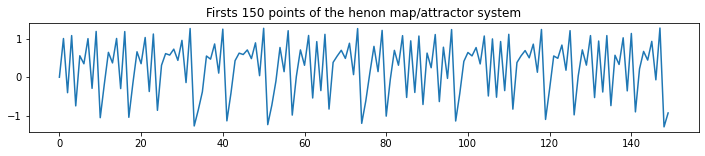

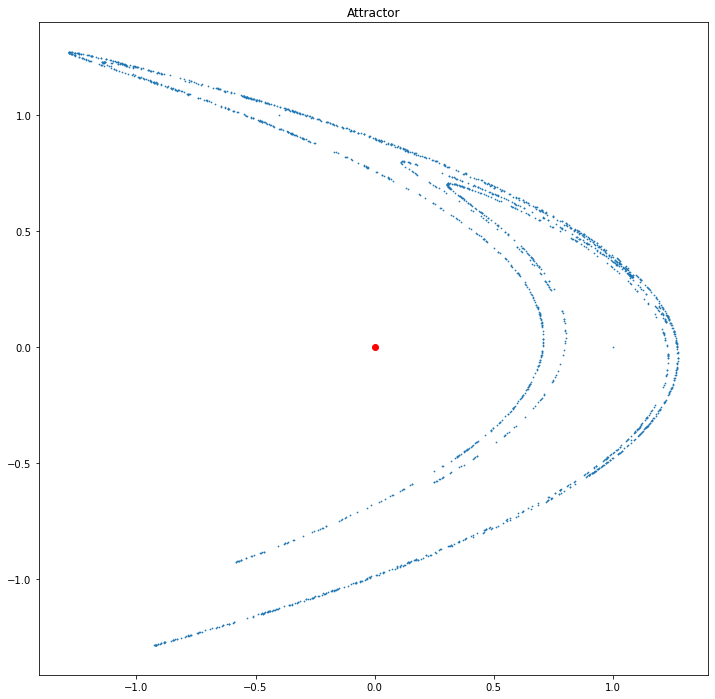

In [3]:
# classic henon attractor
_ = henon_map(a=1.4, b=.3, n=2000, x0=0, y0=0)

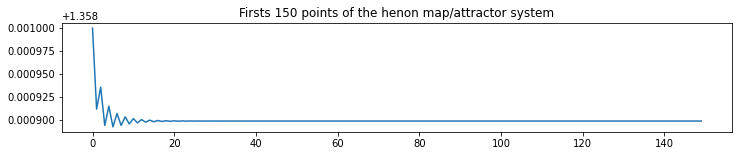

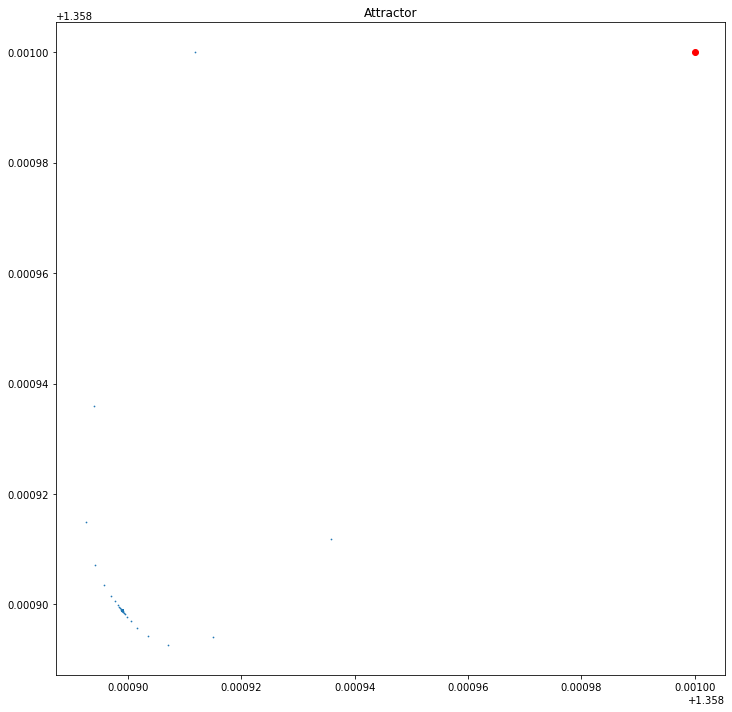

In [4]:
# Converging henon map
_ = henon_map(a=.1, b=.4, n=150, x0=1.359, y0=1.359)

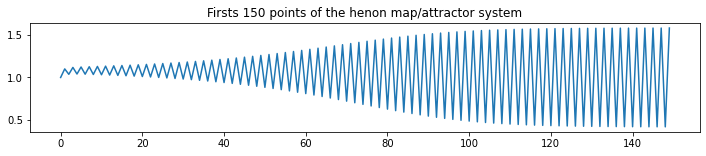

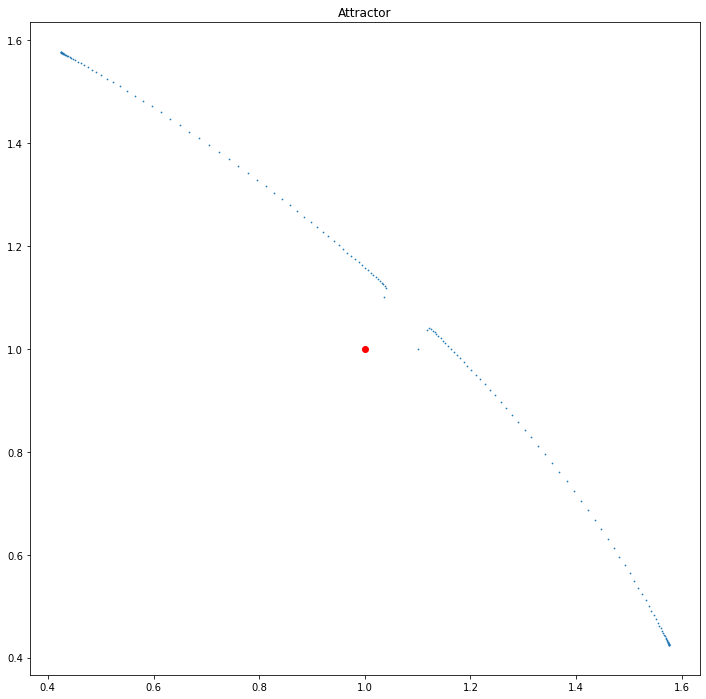

In [5]:
# Non converging henon map
_ = henon_map(a=.3, b=.4, n=150, x0=1, y0=1)

/tmp/ipykernel_2407/2865542369.py:248: RuntimeWarning: overflow encountered in double_scalars
  x = 1 - As[-1]*hm[-1][0]**2 + b*hm[-1][1] + \


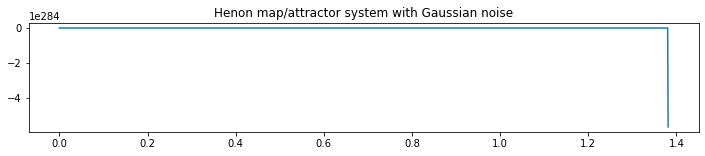

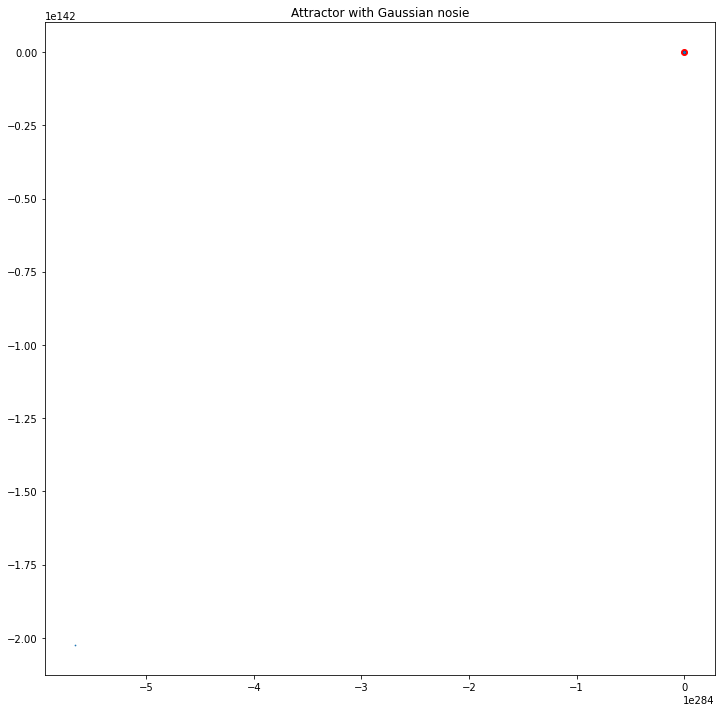

In [6]:
# Reproduces in the first plot the graph available in Figure 2
# May need to be run more than once because of an overflow risk
_ = noisy_henon_map(b=0.3, timestep=0.001, noise_intensity=1, x0=1, y0=1, print_graph=True)

2. **White noises with growing variance**:

White noise with growing variance corresponds to a simulation of $L^p$ norms via Monte Carlo simulations.

> <u>Number of simulations:</u> 10 such that $\sigma \in \{1, 2,\ldots, 10\}$
> 
> The below procedure is repeated for as many times as needed:
> - Generate 4 time series of 100 data points. This results in a 400-point cloud data set is called a "realization" $X_i$ such that:
\begin{align}
\forall i &\in \{1, 2, 3, 4\}\\
\forall j &\in \{1, 2, \ldots, 100\}\\
\delta_i&\sim \text{Unif}[-0.1, 0.1]\\
\forall x_{i,j}\in X_{i}, x_{i,j}&\sim \mathcal{N}(0, (\sigma+\delta_i)^2)\\
\end{align}
> - Perform the paper's workflow on the realization and yield the corresponding $L^1$ and $L^2$ norms
> - Collect the $L^1$ and $L^2$ norms per realization and compute their mean-value

When graphed, this results in a display of the behavior of the $L^1$ and $L^2$ norms in an increasingly noisy environment.

> <u>Use in the paper:</u> 
>
> White noise with a growing variance is used to test the impact of growing noise on the paper's methods, and especially the resulting $L^p$ norms, showing that these norms are linearly increasing functions of the average variance $\sigma^2$ of the data.

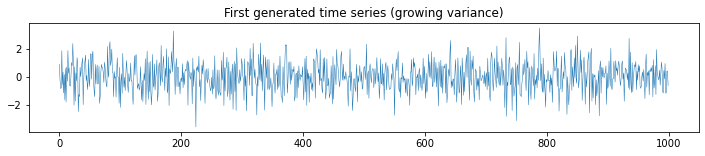

In [7]:
white_noise = white_noise_with_growing_var(10)[1][0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First generated time series (growing variance)")
plt.show()

3. **White noises with Gamma-distributed inverse variance**:

Due to the observation that stock returns usually display fat tails, the use of Gaussian distributions usually fails to properly model stock returns. As such, the use of "superstatistics" are prefered where an underlying time-series generation probability distribution has its parameters themselves following a probability distribution.

In this case, a normal distribution which variance is determined by an inverse gamma distribution is able to approximate a stock market return time series $X$ such that:

\begin{align}
\forall x\in X, x&\sim\mathcal{N}(0, \frac{1}{\sqrt{\gamma}})\\
\gamma &\sim \Gamma(\alpha, \beta) \\
f_{\Gamma(\alpha, \beta)}(\gamma, \alpha, \beta) &= \frac{\beta^\alpha}{\Gamma(\alpha)}\gamma^{\alpha-1}exp(-\beta\gamma),\,\,\gamma\ge0,\alpha, \beta>0
\end{align}

> The following procedure is repeated 100 times (producing 100-point cloud data set of 100 data points each):
> - Generate a 4D time series of 100 data points. This results in a 400-point cloud data set is called a "realization" $X_i$ such that:
\begin{align}
\forall i &\in \{1, 2, 3, 4\}\\
\forall j &\in \{1, 2, \ldots, 100\}\\
\gamma_i&\sim \Gamma(\alpha, \beta)\\
\beta &= 1\\
\alpha &= 8 \text{ for the first 75 realizations, then decreases by 0.25-step}\\
\forall x_{i,j}\in X_{i}, x_{i,j}&\sim \mathcal{N}(0, \frac{1}{\sqrt{\gamma}})\\
\end{align}
> - Perform the paper's workflow on the realization and yield the corresponding $L^1$ and $L^2$ norms
> - Collect the $L^1$ and $L^2$ norms per realization and compute their mean-value

When graphed, this results in a display of the behavior of the $L^1$ and $L^2$ norms which higlights change in regime from a "regular" (low variance) to a "heated" (high variance) regime.

> <span style="color:green">Use in the paper</span>: 
>
> White noise with Gamma-distributed inverse variance is used in the paper to test regime changes in the underlying data via the use of $L^p$ norms, showing that these norms are sensitive to such changes and valuable in the case of financial markets where such changes can occur.

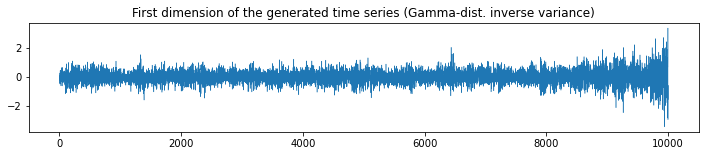

In [8]:
white_noise = white_noise_with_gamma_inverse_var()[0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First dimension of the generated time series (Gamma-dist. inverse variance)")
plt.show()


### 1.2 Data exploration

<u>Importing the four stock index .csv files:</u>

In [9]:
# Sets path and file names
dpath = "data/"
files = ["dowjones.csv", "nasdaq.csv", "russel2000.csv", "sp500.csv"]

# Imports
dowjones   = format_dataframe(pd.read_csv(dpath+files[0]))
nasdaq     = format_dataframe(pd.read_csv(dpath+files[1]))
russel2000 = format_dataframe(pd.read_csv(dpath+files[2]))
sp500      = format_dataframe(pd.read_csv(dpath+files[3]))

<u>Reversing the datasets:</u>

We remark that the four datasets are sorted from the most recent to the oldest entry. We invert this order.

In [10]:
dowjones   = reverse_dataframe(dowjones)
nasdaq     = reverse_dataframe(nasdaq)
russel2000 = reverse_dataframe(russel2000)
sp500      = reverse_dataframe(sp500)

<u>Describing the four stock index datasets:</u>

In [11]:
dowjones.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,9105.862283,9164.009674,9046.451886,9108.768028,1.327529e+08,9108.768028
std,4591.493765,4612.191784,4569.933694,4592.338602,1.080034e+08,4592.338602
min,1892.410034,1903.349976,1845.989990,1879.140015,5.170000e+06,1879.140015
25%,4035.600098,4054.629883,4025.580078,4038.370117,3.070000e+07,4038.370117
50%,9961.139648,10036.940430,9875.129883,9961.919922,1.048900e+08,9961.919922
75%,11872.070312,11968.179688,11803.040039,11871.839844,2.139300e+08,11871.839844
max,19559.939453,19664.970703,19527.830078,19614.810547,7.384400e+08,19614.810547


In [12]:
nasdaq.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,2046.851121,2061.155424,2030.069391,2046.431813,1.272756e+09,2046.431813
std,1308.226234,1316.374729,1298.087048,1307.761834,8.269404e+08,1307.761834
min,325.100006,325.700012,323.000000,325.399994,4.421000e+07,325.399994
25%,804.460022,808.690002,804.460022,807.380005,3.488100e+08,807.380005
50%,1957.260010,1972.310059,1939.560059,1959.239990,1.545720e+09,1959.239990
75%,2658.530029,2675.209961,2637.659912,2657.219971,1.922070e+09,2657.219971
max,5394.149902,5425.520020,5389.100098,5417.359863,4.553600e+09,5417.359863


In [13]:
russel2000.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,541.634331,545.258122,537.669418,541.784923,1.903291e+07,541.784923
std,310.343577,312.363606,308.122820,310.423800,1.785974e+07,310.423800
min,118.309998,118.959999,118.019997,118.300003,5.720000e+05,118.300003
25%,264.049988,265.029999,263.179993,264.140015,3.225700e+06,264.140015
50%,480.959991,484.850006,475.980011,481.130005,1.283300e+07,481.130005
75%,736.500000,742.190002,729.750000,736.590027,3.336120e+07,736.590027
max,1364.430054,1386.449951,1363.699951,1386.369995,1.145623e+08,1386.369995


In [14]:
sp500.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,1048.014023,1054.464612,1041.154037,1048.282910,1.904413e+09,1048.282910
std,515.875484,518.431655,513.113535,515.946592,1.784001e+09,515.946592
min,242.649994,244.250000,240.169998,242.630005,1.499000e+07,242.630005
25%,490.049988,492.890015,490.049988,491.880005,3.247100e+08,491.880005
50%,1111.469971,1118.739990,1105.270020,1111.089966,1.286300e+09,1111.089966
75%,1358.849976,1367.410034,1348.030029,1359.880005,3.335710e+09,1359.880005
max,2241.129883,2251.689941,2237.570068,2246.189941,1.145623e+10,2246.189941


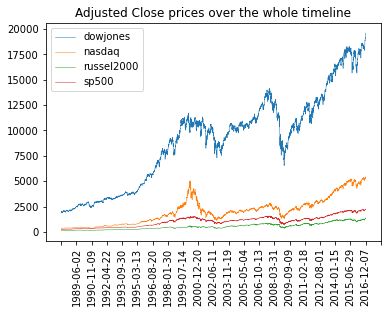

In [15]:
legend = ["dowjones", "nasdaq", "russel2000", "sp500"]

plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close",
                "Adjusted Close prices over the whole timeline")

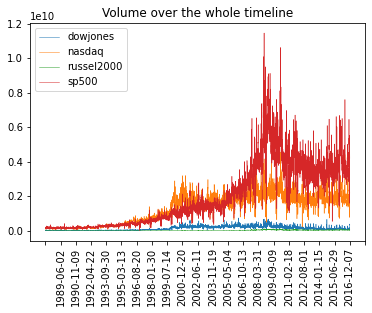

In [16]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume",
                "Volume over the whole timeline")

### 1.3 Computing log-returns and volume percent changes

The logarithm of returns is an ubiquitous quantitative finance transformation procedure of price time series data. 

> Given a price time series $P$ of length $n\in\mathbb{N}_+$ with components $p_i\,\,\forall i\in\{0,\ldots,n\}$.
>
> $P$ can be transformed into a times series $R$ of returns $r_i\,\,\forall i\in\{1,\ldots,n\}$ such that:

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= \frac{p_i-p_{i-1}}{p_{i-1}}
\end{align}

The main benefit of using relative metrics like returns compared to absolute metrics like prices is normalization, a requirement for many multidimensional statistical analysis setups. However, it is more common to encounter logarithmic returns due to several valuable properties.

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= log(p_i)-log(p_{i-1})
\end{align}

<u>Properties of log-returns:</u>

1. **Log-normality**: Prices are usually assumed to be log-normally distributed in finance.

2. **Approximate raw-log equality**: Given $r^{\text{absolute}}_i$ the return at timestep $i$ of a price time series $P$, and $r_i^{\text{log}}$ the corresponding log-return, we find the following approximation when $r^{\text{absolute}}_i<<1$:

$$\forall i\in\{1,\ldots,n\},\,r^{\text{absolute}}_i\approx log(1+r^{\text{absolute}}_i) = r_i^{\text{log}}$$

3. **Time additivity**: Given an ordered sequence of $n$ prices $p$, the corresponding compounding return $r$ corresponds to the product:

$$1+r=\underset{i=1}{\overset{n}{\Pi}}(1+r_i)$$

This formula is not computationally efficient and, given the product of normally distributed variables are not normally distributed, we would prefer additions. Using the properties of the logarithms, we can rewrite:

$$log(1+r)=\underset{i=1}{\overset{n}{\sum}}log(1+r_i)$$

4. **Numerical stability**: Multiplication of small numbers can lead to airthmetic underflow compared to additions. 

*Source:* [quantivity, feb, 2011](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

<u>Computing log returns:</u>

Given those properties, we are interested in computing the log returns of each type of price data available to us: Open, Close, High, Low, and Adj. Close.

In [17]:
dowjones   = compute_log_returns(dowjones)
nasdaq     = compute_log_returns(nasdaq)
russel2000 = compute_log_returns(russel2000)
sp500      = compute_log_returns(sp500)

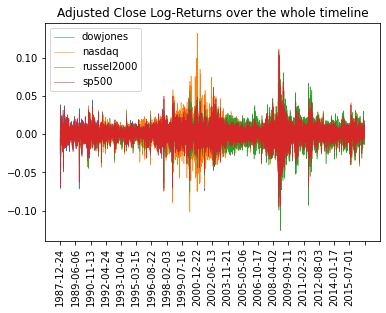

In [18]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close_lr",
                "Adjusted Close Log-Returns over the whole timeline")

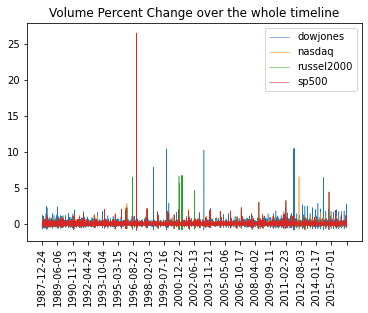

In [19]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume_pct_change",
                "Volume Percent Change over the whole timeline")

# 2. Step 2 - Persistence Landscape From Scratch

In this section we have implemented a persistence landscape function that works on the basis we already have a pre-computed set persistence diagrams.

We have persistence diagrams computed using the [GUDHI library](https://gudhi.inria.fr/doc/3.5.0/)) and the persistence landscape computation algorithm (extracted from Bubenik and Dlotko Pawel's seminal paper "[A persistence landscapes toolbox for topological statistics](https://hal.inria.fr/hal-01258875/file/PersistenceLandscapes_arxiv_v3.pdf)", Journal of
Symbolic Computation, Elsevier, 2016, is reproduced below.

<div>
<img src="data/persistence_landscape_algo.png" width="700"/>
</div>

<u>Function implementations:</u>

The functions `compute_persistence_landscape` and `compute_persistence_landscapes` are reproduced in Markdown format below, but are loaded in memory in **Section d** at the very start of this notebook (You will also find there the functions `compute_persistence_diagrams`, `compute_persistence_diagrams`).

> <u>*Note on memory saving*:</u>
>
> Computing and returning lists of whole persistence diagrams via GUDHI has resulted in memory overflows that are impossible to garbage-collect via Python's gc library. As such, when the number of computation is large, one can bypass the generic process of the functions `compute_persistence_landscape` and `compute_persistence_landscapes` by pre-fetching the homology class of dimension $k$ at the moment of diagram computation -- rather than collecting whole diagrams which are stored in memory in full.

```Python

def compute_persistence_landscape(
    diagram:            np.ndarray,         # diagram range
    endpoints:          list,               # endpoints
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    """
    Given a persistence diagram of 1D loops of a given
    time series, computes the corresponding persistence landscape.
    Inspired from: https://github.com/MathieuCarriere/sklearn-tda/
                   blob/master/sklearn_tda/vector_methods.py
    """
    # If the diagram is empty, return an empty landscape
    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((n_landscapes, resolution))
    # Renames the min-max range of the given diagram
    diagram_range = endpoints
    # Extracts the homology class from the diagram in case the 
    # computation mode  is not memory-saving. I.e. the dimension
    # class was not pre-fetched at the diagram computation level
    if not memory_saving:
        diagram = diagram.persistence_intervals_in_dimension(homology_dimension)
    # Initializes important variables
    x_range        =  np.linspace(diagram_range[0], 
                                  diagram_range[1],
                                  resolution)
    step           = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = \
        np.zeros([n_landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]
    # Initializes important anonymous functions
    compute_x_subrange = lambda x: int(np.ceil(x/step))
    # Computes the persistence landscape coverage, here
    # the x- and y-axes ranges
    for x, y in diagram:
        # Populates thex-axis range as defined for each 
        # persistence diagram point
        min_point = x - diagram_range[0]
        mid_point = 0.5*(x+y) - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)
        # Populates the y-axis values given the computed
        # x-axis range for that part of the resulting landscape
        if minimum_x<resolution and maximum_x>0:
            y_value = diagram_range[0] + minimum_x * step - x
            for z in range(minimum_x, middle_x):
                computed_y_values[z].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x * step
            for z in range(middle_x, maximum_x):
                computed_y_values[z].append(y_value)
                y_value -= step
    # Computes for each resolution the corresponding landscape
    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(n_landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = \
                computed_y_values[i][j]
    return computed_landscapes_at_given_resolution
    
def compute_persistence_landscapes(
    diagrams:           np.ndarray,         # diagram D
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    """
    Given a list of persistence diagrams of 1D loops of a given
    time series, computes the corresponding persistence landscapes.
    """
    k    = homology_dimension
    # Declares the anonymous functions helping to compute the
    # diagram endpoints different depending on the memory saving mode
    if memory_saving:
        minp = lambda d: np.min(d) if len(d)>0 else 0
        maxp = lambda d: np.max(d) if len(d)>0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")
    # Transforms all diagrams into landscapes
    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            homology_dimension,       # k dimensions
            n_landscapes,             # m landscapes
            resolution,               # n nodes
            memory_saving
        ) for diag in diagrams
    ]
    return landscapes

```

<u>Applications:<u>
  
1. **Noisy Hénon Maps** 
    
We start with replicating the paper's noisy Hénon map generation process. We will reuse the parameters previously stated in **Section 1.1 "*Experimentation on synthetic data*"**. 
    
> *Of note*: The stochastic process might fail, which will give rise to a warning (while training the first cell below) or an error (while running the second cell below -- in that case, the computation of a landscape will have failed). Sometimes you will have to rerun the first cell below a few times.
    
*Parameter declaration and data generation*:

In [23]:
# Declares parameter b range for the Hénon Map generation
b_range = [0.27, 0.28, 0.29, 0.3]

# Simulates a 4D matrix composed of four generated
# noisy Hénon Maps
simulation = [noisy_henon_map(b=b, 
                              timestep=0.001, 
                              noise_intensity=1, 
                              x0=1, y0=1, 
                              print_graph=False)
              for b in b_range]

# Formats the simulations as a Pandas DataFrame
data = pd.DataFrame(np.array(simulation).T,
                    columns = [f"b_{b}" for b in b_range])
data.head()

,b_0.27,b_0.28,b_0.29,b_0.3
0,1.000000,1.000000,1.000000,1.000000
1,1.296264,1.299334,1.327877,1.328029
2,1.292155,1.271247,1.327418,1.263331
3,1.359320,1.346309,1.401025,1.433150
4,1.331242,1.317354,1.361628,1.430609


*Computation of the diagrams and landscapes*

> *Of note*: as-is, the computation of the diagrams is memory intensive and you might need to restart the kernel between run depending on the size of the original dataset. This is due to the fact that the function `compute_persistence_diagrams` returns a list of *full* diagrams and not just the 1-loop diagrams as per the paper.
>
> For later reference, this is easily solved by moving the use of the method `.persistence_intervals_in_dimension(k)` from the function `compute_persistence_landscape` to `compute_persistence_diagram` and updating the other function accordingly.

In [24]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 200

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops if not
# computed with memory_saving
diagrams   = compute_persistence_diagrams(data, 
                                          w_window_size,
                                          memory_saving=(True, k_homology_dimension))
landscapes = compute_persistence_landscapes(diagrams, 
                                            k_homology_dimension, 
                                            m_landscape, 
                                            n_nodes,
                                            memory_saving=True)

*Computation of the $L^1$ and $L^2$ norms*

In [25]:
norms_df = compute_persistence_landscape_norms(landscapes)
df = pd.DataFrame(norms_df, columns=["L1", "L2"])

*$L^1$ and $L^2$ norms visualization*

<AxesSubplot:>

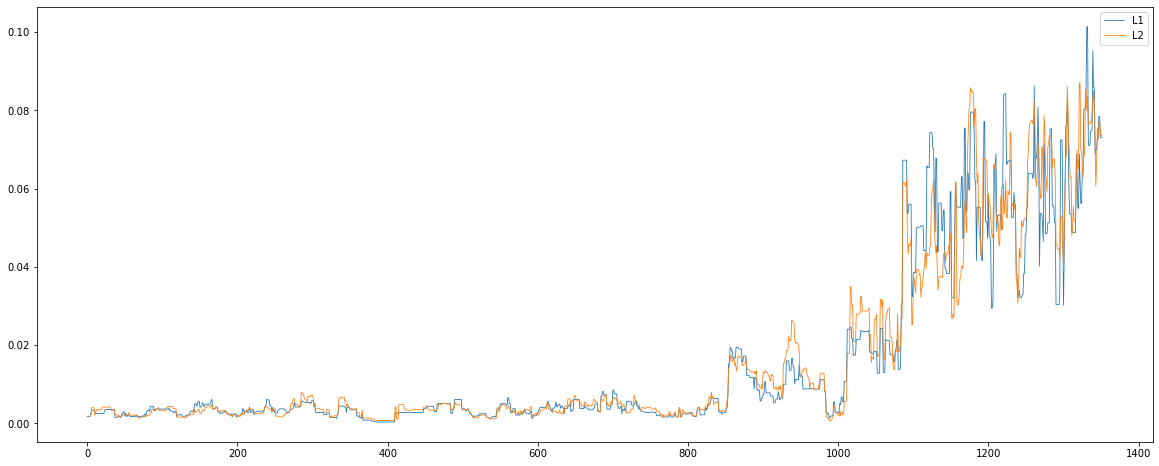

In [26]:
df.plot(figsize=(20, 8), lw=0.8)

As such, we demonstrate that the paper's workflow is able to evidence a change in regime as exemplified in a noisy Hénon Map stochastic process. The process obtained above is very similar to the results shown in the paper's Figure 4 on page 13.

2. **White noises with growing variance** 

We now replicate the paper's White noise with growing variance generation process. We will reuse the parameters previously stated in **Section 1.1 "*Experimentation on synthetic data*"**. 
    
> *Of note*: The stochastic process might also fail, which will give rise to a warning (while training the first cell below) or an error (while running the second cell below -- in that case, the computation of a landscape will have failed). Sometimes you will have to rerun the first cell below a few times.
    
*Data generation*:

In [28]:
# Simulates 10 4D matrices (with increasing variance) and
# Formats each as a Pandas DataFrame
simulations = white_noise_with_growing_var(10)
data = {k: pd.DataFrame(simulations[k].T) for k in simulations.keys()}

# Print an example header
data[1].head()

,0,1,2,3
0,2.257806,-1.397771,-1.492377,-1.647851
1,1.647723,-0.236026,1.632369,-1.234743
2,-0.739280,0.555113,-0.396527,1.088983
3,0.747643,-0.919172,0.837299,0.907467
4,1.137503,-0.733743,-0.002271,-1.556953


*Computation of the diagrams and landscapes*

> *Of note*: as-is, the computation of the diagrams is memory intensive and you might need to restart the kernel between run depending on the size of the original dataset. This is due to the fact that the function `compute_persistence_diagrams` returns a list of *full* diagrams and not just the 1-loop diagrams as per the paper.
>
> For later reference, this is easily solved by moving the use of the method `.persistence_intervals_in_dimension(k)` from the function `compute_persistence_landscape` to `compute_persistence_diagram` and updating the other function accordingly.

In [29]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 1000

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops
c_diagrams   = lambda d, w: compute_persistence_diagrams(
    d, w, memory_saving=(True, k_homology_dimension)
)
c_landscapes = lambda d, k, m, n: compute_persistence_landscapes(
    d,k,m,n, memory_saving=True
)
landscapes   = {k: c_landscapes(c_diagrams(data[k], w_window_size), 
                                k_homology_dimension, m_landscape, n_nodes) 
                for k in data.keys()}

*Computation of the $L^1$ and $L^2$ norms*

In [30]:
# Computes the L1 and L2 norms of the 10 white-noises with gamma-distributed variance
# processes
c_norms = lambda l: compute_persistence_landscape_norms(l)
norms_dfs = {k: pd.DataFrame(c_norms(landscapes[k]), columns=["L1", "L2"]) 
             for k in landscapes.keys()}

# Extracts the L1 norms in a single Pandas DataFrame
L1_norms = np.array([norms_dfs[k]["L1"] for k in norms_dfs.keys()]).T
L1_norms = pd.DataFrame(L1_norms, columns=[f"var_{v+1}" for v in range(10)])

# Extracts the L2 norms in a single Pandas DataFram
L2_norms = np.array([norms_dfs[k]["L2"] for k in norms_dfs.keys()]).T
L2_norms = pd.DataFrame(L2_norms, columns=[f"var_{v+1}" for v in range(10)])

*$L^1$ and $L^2$ norms visualization*

<AxesSubplot:>

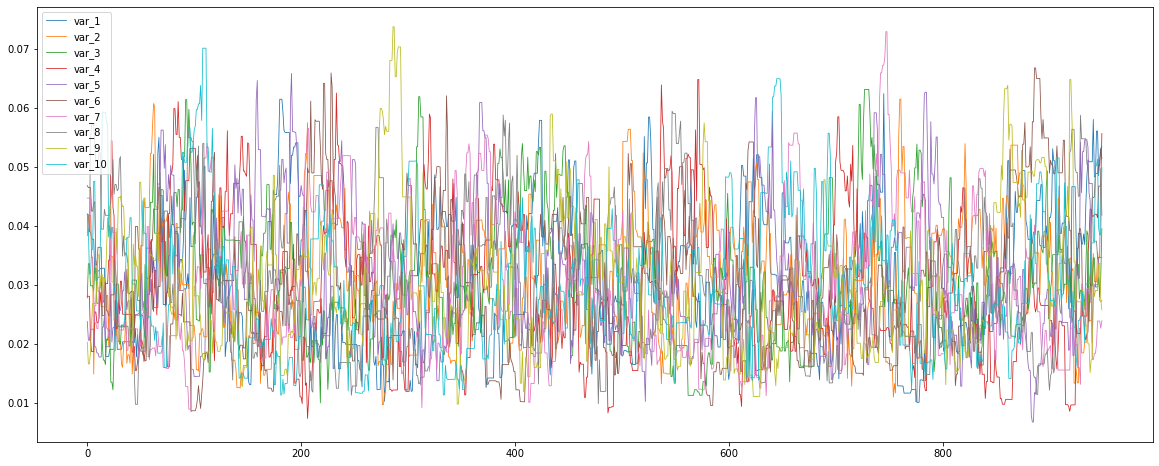

In [31]:
L1_norms.plot(figsize=(20, 8), lw=0.8)

<AxesSubplot:>

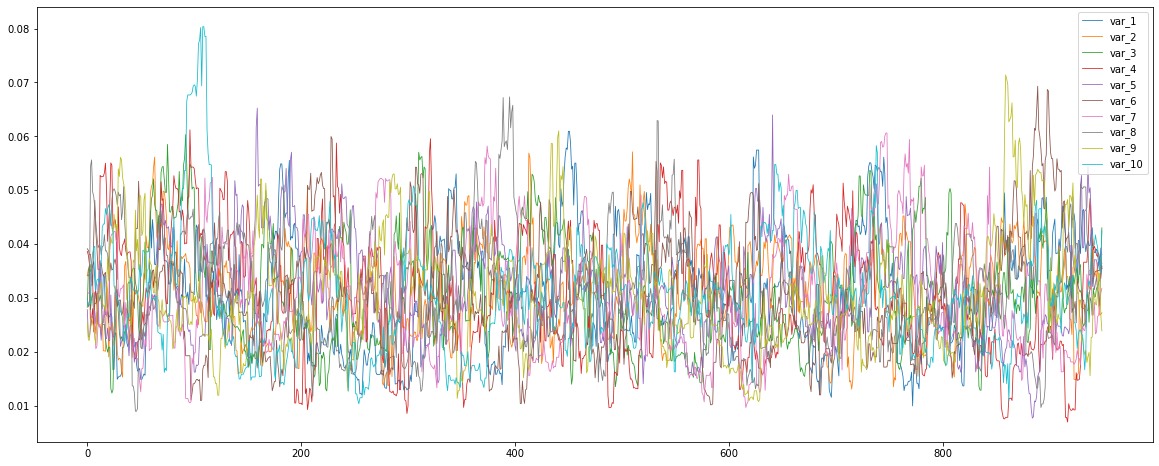

In [32]:
L2_norms.plot(figsize=(20, 8), lw=0.8)

As such, we demonstrate that the paper's workflow and the use of persistence landscape is robust to increasing noise. We see that the growing variance does not seem to affect the resulting computation of the $L^1$ and $L^2$ norms.

3. **White noises with Gamma-distributed inverse variance** 

We now replicate the paper's White noise with Gamma-distributed inverse variance generation process. We will reuse the parameters previously stated in **Section 1.1 "*Experimentation on synthetic data*"**. 
    
> *Of note*: The stochastic process might also fail, which will give rise to a warning (while training the first cell below) or an error (while running the second cell below -- in that case, the computation of a landscape will have failed). Sometimes you will have to rerun the first cell below a few times.
    
*Data generation*:

In [37]:
# Simulates a 4D matrix made with a gamma distributed variance
data = pd.DataFrame(white_noise_with_gamma_inverse_var().T)

# Print an example header
data.head()

,0,1,2,3
0,-0.392767,-0.198822,-0.050884,0.251716
1,0.151639,0.089641,-0.387336,-0.186708
2,0.262222,-0.071026,0.208296,0.241611
3,-0.121185,-0.049568,-0.184951,-0.368429
4,0.103515,-0.138709,0.199930,-0.245920


*Computation of the diagrams and landscapes*

> *Of note*: as-is, the computation of the diagrams is memory intensive and you might need to restart the kernel between run depending on the size of the original dataset. This is due to the fact that the function `compute_persistence_diagrams` returns a list of *full* diagrams and not just the 1-loop diagrams as per the paper.
>
> For later reference, this is easily solved by moving the use of the method `.persistence_intervals_in_dimension(k)` from the function `compute_persistence_landscape` to `compute_persistence_diagram` and updating the other function accordingly.

In [38]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 1000

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops
diagrams   = compute_persistence_diagrams(data, 
                                          w_window_size,
                                          memory_saving = (True, k_homology_dimension))
landscapes = compute_persistence_landscapes(diagrams, 
                                            k_homology_dimension, 
                                            m_landscape, 
                                            n_nodes,
                                            memory_saving=True)

*Computation of the $L^1$ and $L^2$ norms*

In [39]:
norms_df = compute_persistence_landscape_norms(landscapes)
df = pd.DataFrame(norms_df, columns=["L1", "L2"])

*$L^1$ and $L^2$ norms visualization*

<AxesSubplot:>

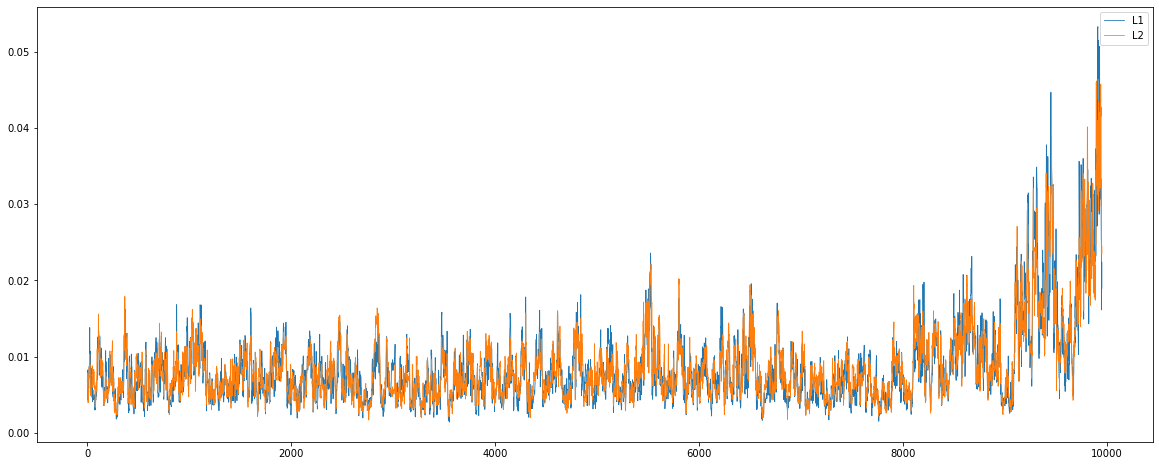

In [40]:
df.plot(figsize=(20, 8), lw=0.8)

As such, we also demonstrate here that the paper's workflow and the use of persistence landscape is sensitie to transitions in the state of a system "from a regular to a 'heated' regime."

# 3. Step 3 - Reproducing the Paper's Empirical Analysis

In [20]:
data = np.array([
    dowjones["adj_close_lr"][1:],
    nasdaq["adj_close_lr"][1:], 
    russel2000["adj_close_lr"][1:], 
    sp500["adj_close_lr"][1:]]).T
columns = ["dowjones", "nasdaq", "russel2000", "sp500"]
index   = dowjones["date"][1:]

data = pd.DataFrame(data, columns=columns, index=index)

In [31]:
def reproduce_paper_process(
    data,
    w_window_size, 
    k_homology_dimension,
    m_landscape,
    n_nodes,
    memory_saving=(False, 1),
    compute_gif_landscape = False
):
    """
    """
    # Abbreviates parameters
    w   = w_window_size
    k   = k_homology_dimension
    m   = m_landscape
    n   = n_nodes
    mem = memory_saving
    # Computes landscapes
    diagrams   = compute_persistence_diagrams(data, w, memory_saving=mem)
    landscapes = compute_persistence_landscapes(diagrams, k, m, n, mem[0])
    # Computes norms
    norms_df   = compute_persistence_landscape_norms(landscapes)
    # Computes and print graph of dot-com bubble
    df = pd.DataFrame(norms_df[2027:3200], 
                      columns = ["L1", "L2"], 
                      index   = data.index[2027+w:3200+w])
    ax = df.plot(figsize = (20, 8), 
                lw       = 0.8, 
                title    = "Persistence landscapes' L1 and L2 " + \
                           "norms towards Dotcom bubble")
    ax.axvline(x         = np.where([df.index=="2000-01-10"])[1][0], 
               color     = 'r', 
               linestyle = (0, (3, 5, 1, 5, 1, 5)), 
               label     = 'America Online/Time Warner merger')
    ax.legend()
    plt.show()
    # Computes the full L1 and L2 time series plot
    df = pd.DataFrame(norms_df, 
                      columns  = ["L1", "L2"],
                      index    = data.index[w:])
    ax = df.plot(figsize = (18, 7), 
                 lw      = 0.8, 
                 ylabel  = "L^p norm value",
                 title   = "Full Persistence landscapes' L1 and L2 norms")
    ax.axvline(x         = np.where([df.index=="2000-01-10"])[1][0], 
               color     = 'r', 
               linestyle = (0, (3, 5, 1, 5, 1, 5)), 
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df.index=="2008-09-15"])[1][0], 
               color     = 'r', 
               linestyle = '--', 
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()

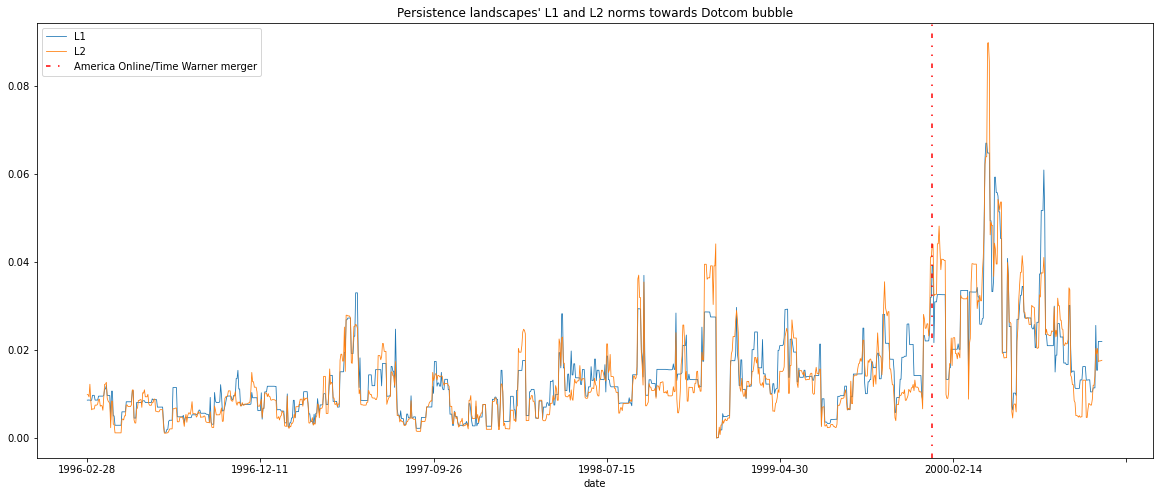

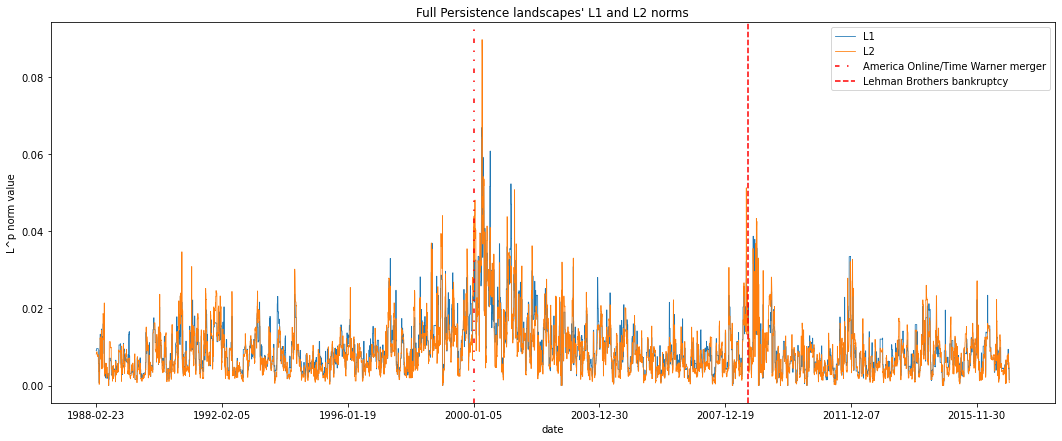

In [32]:
reproduce_paper_process(data, 40, 1, 5, 1000, (True, 1), False)

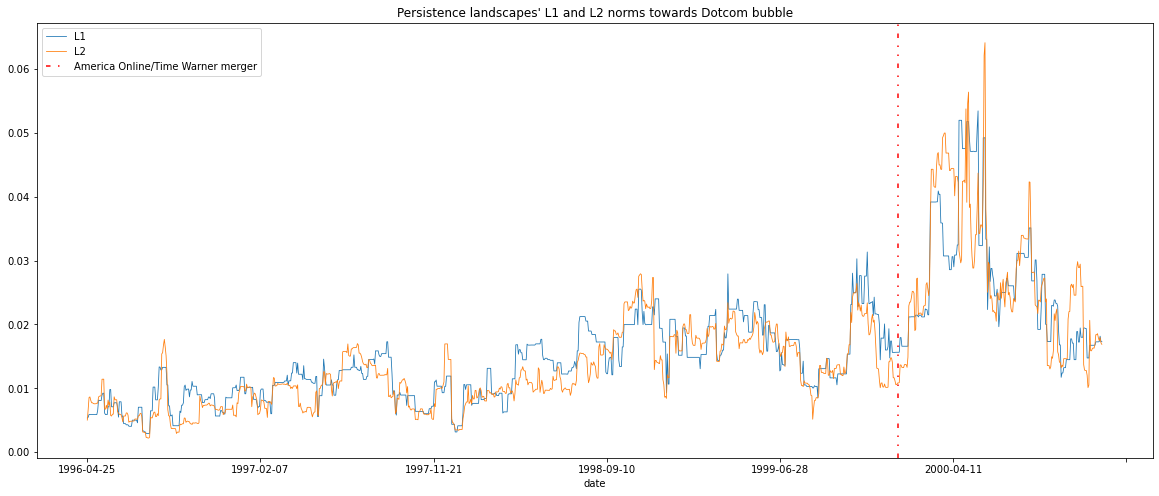

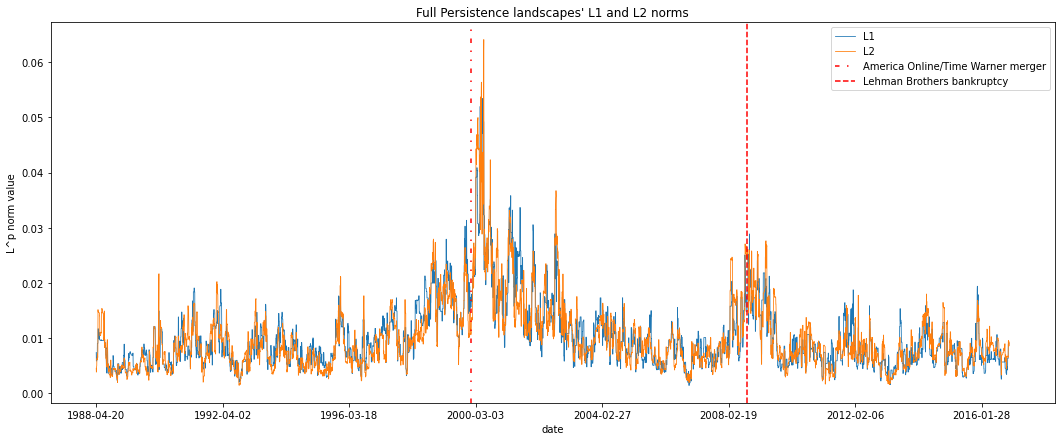

In [33]:
reproduce_paper_process(data, 80, 1, 5, 1000, (True, 1), False)

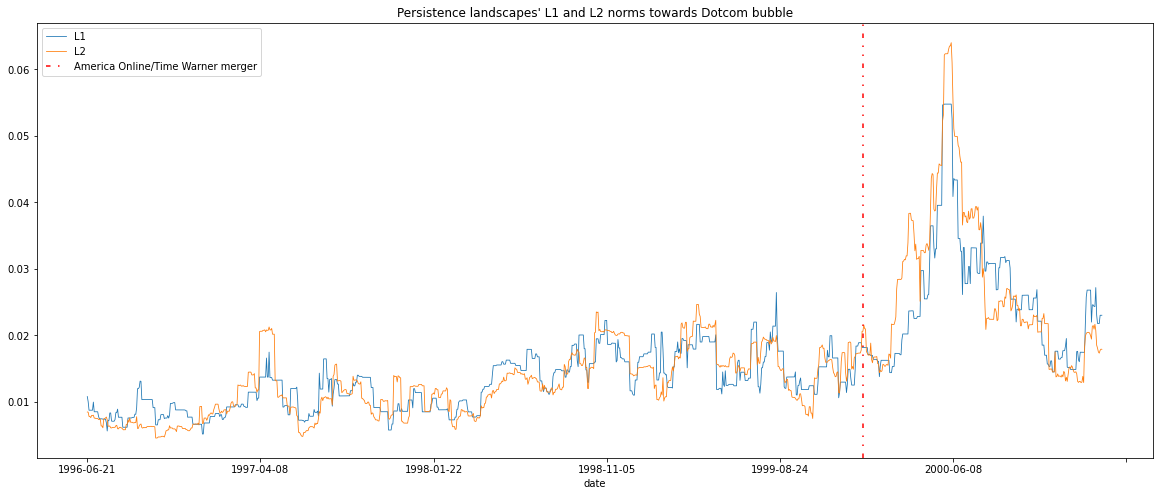

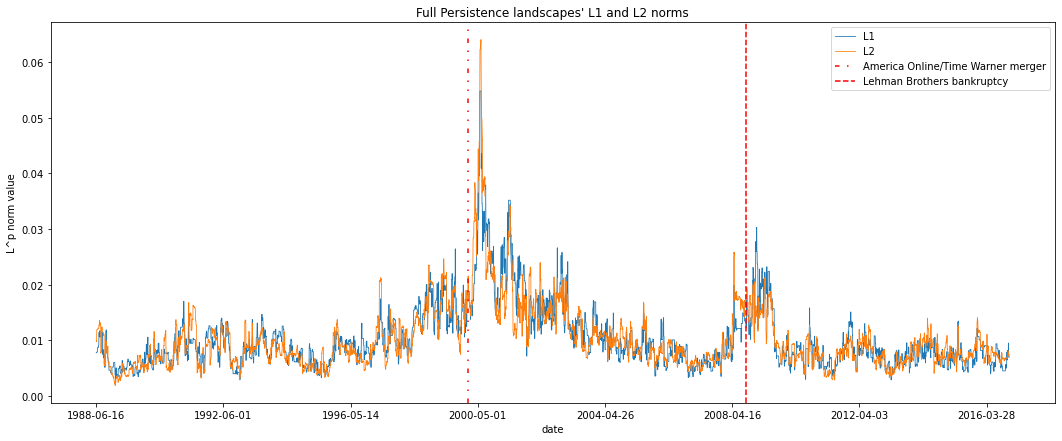

In [34]:
reproduce_paper_process(data, 120, 1, 5, 1000, (True, 1), False)

In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()
 
# creating a plot
lines_plotted = [plt.plot([]) for _ in range(5)]
lines_plotted = [l[0] for l in lines_plotted]

x = list(range(1000))
plt.xlim(0,1000)
plt.ylim(0,0.002) 
plt.title("Landscape")

# function takes frame as an input
def AnimationFunction(frame):
    plt.title(f"Landscape at window = {frame}")
    for l in range(5):
        lines_plotted[l].set_data((x, landscapes[frame][l]))

anim_created = FuncAnimation(Figure, AnimationFunction, frames=7200, interval=10, repeat=False)
    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()

# 4. Step 4 - Exploring Further Avenues